# Importing Relevant Packages

In [3]:
# pip install yfinance

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../Scripts"))
from download_data import StockData
from preprocessing import DataPreprocessor
from eda import TeslaStockAnalysis

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Task 1: Preprocess and Explore the Data

### Load and Clean Data

In [ ]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2020-01-01"
end_date = "2025-01-31"

# Create instance of StockData
stock_data = StockData(tickers, start_date, end_date)

In [4]:
stock_data.download_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Price           Close                               High              \
Ticker            BND         SPY        TSLA        BND         SPY   
Date                                                                   
2020-01-02  72.948746  301.194885   28.684000  73.070370  301.213446   
2020-01-03  73.209381  298.914276   29.534000  73.226760  300.054650   
2020-01-06  73.122505  300.054535   30.102667  73.244129  300.137973   
2020-01-07  73.061676  299.210876   31.270666  73.148549  299.961845   
2020-01-08  72.948746  300.805511   32.809334  73.148554  302.038574   
...               ...         ...         ...        ...         ...   
2025-01-24  71.805977  607.969971  406.579987  71.855810  610.780029   
2025-01-27  72.184738  599.369995  397.149994  72.204677  599.690002   
2025-01-28  72.144867  604.520020  398.089996  72.154837  605.369995   
2025-01-29  72.104996  601.809998  389.100006  72.254510  604.130005   
2025-01-30  72.204674  605.039978  400.279999  72.294378  606.599976   

Price                         Low                               Open  \
Ticker            TSLA        BND         SPY        TSLA        BND   
Date                                                                   
2020-01-02   28.713333  72.913995  299.025418   28.114000  72.957435   
2020-01-03   30.266666  73.061696  297.699745   29.128000  73.131197   
2020-01-06   30.104000  73.070382  297.013540   29.333332  73.235447   
2020-01-07   31.441999  73.035615  298.756566   30.224001  73.148549   
2020-01-08   33.232666  72.887934  299.155231   31.215334  73.087742   
...                ...        ...         ...         ...        ...   
2025-01-24  418.880005  71.636531  606.799988  405.779999  71.766106   
2025-01-27  406.690002  72.025262  594.640015  389.000000  72.104996   
2025-01-28  400.589996  71.975421  597.250000  386.500000  72.154837   
2025-01-29  398.589996  71.935550  599.219971  384.480011  72.194707   
2025-01-30  412.500000  72.144864  600.719971  384.410004  72.224605   

Price                                Volume                       
Ticker             SPY        TSLA      BND       SPY       TSLA  
Date                                                              
2020-01-02  299.961822   28.299999  5511000  59151200  142981500  
2020-01-03  297.755370   29.366667  5368300  77709700  266677500  
2020-01-06  297.134071   29.364668  3710400  55653900  151995000  
2020-01-07  299.479722   30.760000  3029900  40496400  268231500  
2020-01-08  299.405545   31.580000  3674400  68296000  467164500  
...                ...         ...      ...       ...        ...  
2025-01-24  609.809998  414.450012  5555700  34604700   56427100  
2025-01-27  594.809998  394.799988  8621200  70361100   58125500  
2025-01-28  600.619995  396.910004  4424300  44433300   48910700  
2025-01-29  603.719971  395.209991  5780200  37177400   68033600  
2025-01-30  603.960022  410.779999  5622300  39281300   98092900  

[1277 rows x 15 columns]

In [5]:
close_df, high_df, low_df, open_df, volume_df = stock_data.extract_price_categories()

In [6]:
close_df, high_df, low_df, open_df, volume_df = stock_data.reset_indexes()

In [7]:
close_df, high_df, low_df, open_df, volume_df = stock_data.melt_data()

### Alternatively I can run it only using this

In [8]:
# Process the data
stock_data.process_data()

[*********************100%***********************]  3 of 3 completed


In [8]:
# Get the merged DataFrame
stock_data.merge_data()
df_merged = stock_data.get_merged_data()

In [10]:
df_merged.head()

,Date,Ticker,Open,Low,Volume,High,Close
0,2020-01-02,TSLA,28.299999,28.114000,142981500,28.713333,28.684000
1,2020-01-03,TSLA,29.366667,29.128000,266677500,30.266666,29.534000
2,2020-01-06,TSLA,29.364668,29.333332,151995000,30.104000,30.102667
3,2020-01-07,TSLA,30.760000,30.224001,268231500,31.441999,31.270666
4,2020-01-08,TSLA,31.580000,31.215334,467164500,33.232666,32.809334


In [9]:
data = df_merged

In [89]:
tsla = data[data.Ticker=='TSLA']

## Preprocessing

In [90]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(tsla)

### Handling Duplicates

In [91]:
# Apply data cleaning and transformation steps
preprocessor.handle_duplicates()

Removed 0 duplicate rows.


### Handle Missing Values

In [92]:
preprocessor.handle_missing_values()

Filled 0 missing values.


### Check Outlier

In [93]:
preprocessor.check_outliers()

Outlier count per column: {'Open': 80, 'Low': 77, 'Volume': 92, 'High': 81, 'Close': 83}


### Check Datatypes

In [94]:
preprocessor.check_data_types()


Data Types:
 Date      datetime64[ns]
Ticker            object
Open             float64
Low              float64
Volume             int64
High             float64
Close            float64
dtype: object


### Data Normalization

In [95]:
# Processed Data
processed_data = preprocessor.Normalized_data()
processed_data.head()

,Open,Low,Volume,High,Close,Date
0,0.007363,0.010933,0.128385,0.003732,0.010098,2020-01-02
1,0.009728,0.013269,0.268205,0.007098,0.011963,2020-01-03
2,0.009724,0.013742,0.138573,0.006745,0.013211,2020-01-06
3,0.012818,0.015794,0.269962,0.009644,0.015774,2020-01-07
4,0.014637,0.018077,0.494826,0.013524,0.019150,2020-01-08


In [96]:
processed_data.shape

(1277, 6)

In [98]:
# processed_data.index

### Exploratory Data Analysis (EDA)

In [99]:
# Sort index to ensure chronological order
df = processed_data

In [100]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Sort by the new index
df = df.sort_index()


In [101]:
df.head()

,Open,Low,Volume,High,Close
Date,,,,,
2020-01-02,0.007363,0.010933,0.128385,0.003732,0.010098
2020-01-03,0.009728,0.013269,0.268205,0.007098,0.011963
2020-01-06,0.009724,0.013742,0.138573,0.006745,0.013211
2020-01-07,0.012818,0.015794,0.269962,0.009644,0.015774
2020-01-08,0.014637,0.018077,0.494826,0.013524,0.019150


In [102]:
# Initialize the analysis class
ts_analysis = TeslaStockAnalysis(df)

### Visualize Closing Prices

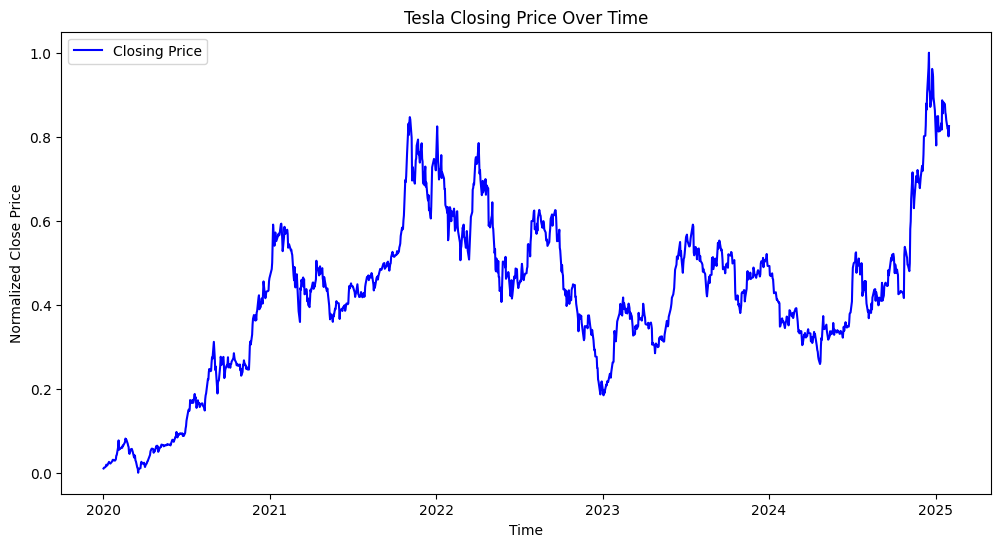

In [103]:
# Run Exploratory Data Analysis
ts_analysis.plot_closing_price()

### Calculate Daily Returns

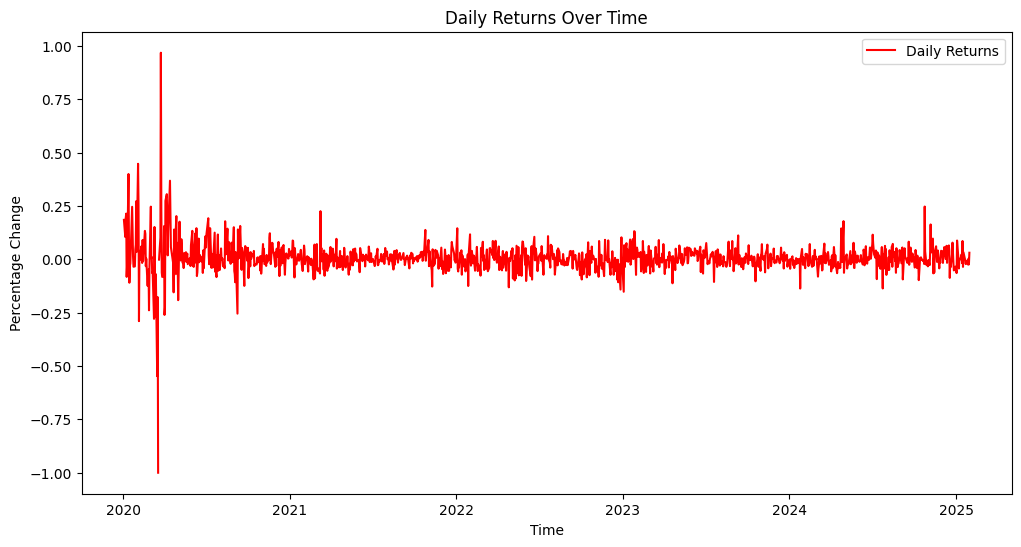

In [104]:
ts_analysis.calculate_daily_returns()

In [105]:
outliers = ts_analysis.detect_outliers()

Identified 22 outlier days with extreme returns.


In [106]:
outliers

,Date,Open,Low,Volume,High,Close,Daily Returns,Z-Score
7,2020-01-13,0.017564,0.021727,0.416379,0.017444,0.023936,0.399470,5.430545
12,2020-01-21,0.022997,0.027318,0.268629,0.020759,0.027203,0.245847,3.316523
19,2020-01-30,0.038103,0.041076,0.458565,0.035535,0.040896,0.272194,3.679089
21,2020-02-03,0.044204,0.049601,0.764766,0.055072,0.061255,0.447313,6.088923
22,2020-02-04,0.075144,0.074226,1.000000,0.081484,0.076915,0.255647,3.451390
23,2020-02-05,0.066318,0.054299,0.787805,0.063716,0.054629,-0.289746,-4.053834
38,2020-02-27,0.052530,0.048907,0.378392,0.048375,0.046482,-0.238996,-3.355459
40,2020-03-02,0.049759,0.051621,0.309177,0.048941,0.055934,0.246537,3.326017
45,2020-03-09,0.034107,0.039079,0.256255,0.037286,0.036096,-0.278969,-3.905534
48,2020-03-12,0.030484,0.030058,0.287375,0.027392,0.029156,-0.269880,-3.780461


### Decompose Tesla’s Stock Price (Trend, Seasonality, Residuals)

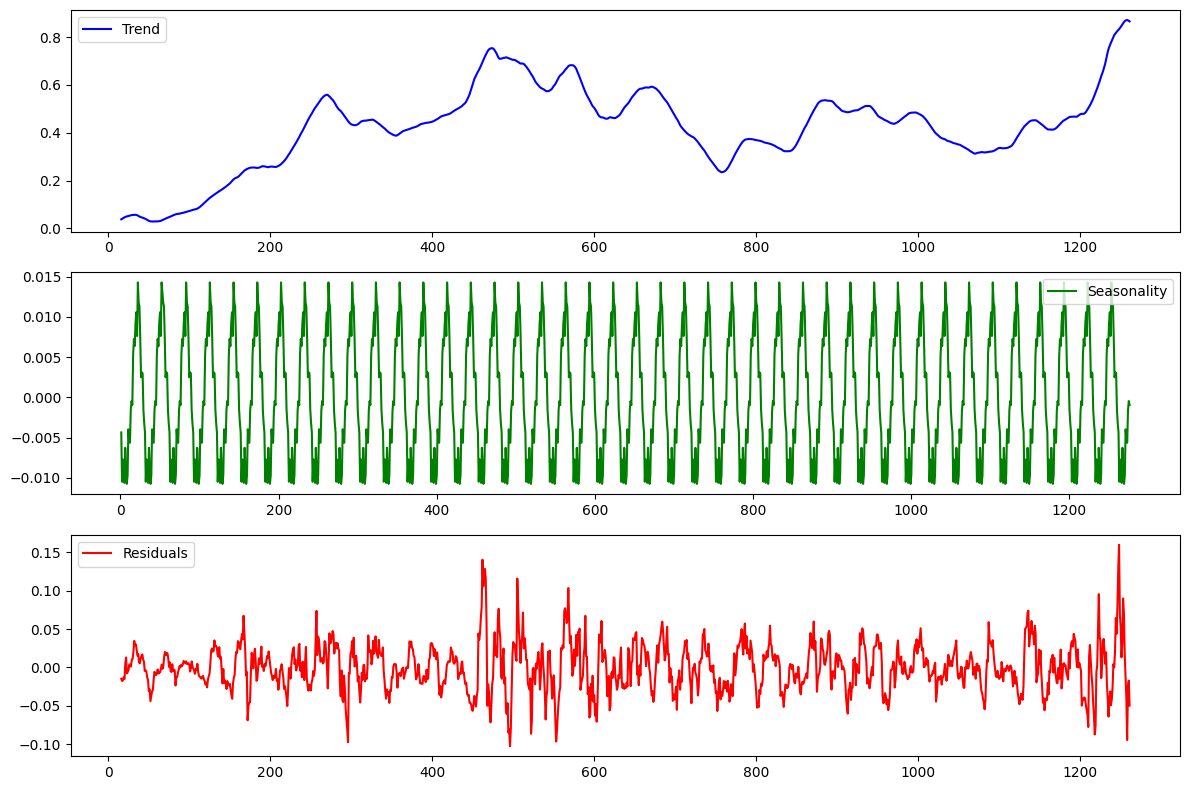

In [107]:
# Perform Trend & Seasonality Analysis
ts_analysis.decompose_time_series()

### Rolling Volatility (Standard Deviation)

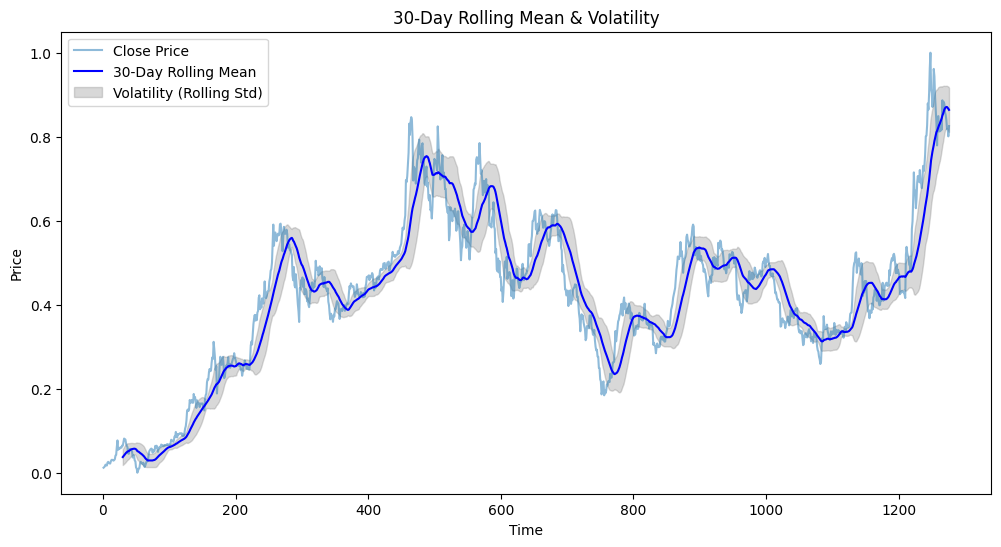

In [108]:
# Analyze Volatility & Risk
ts_analysis.rolling_volatility_analysis(window=30)

In [109]:
ts_analysis.risk_analysis()

VaR (95% confidence): -0.1151
Sharpe Ratio: 0.0666


## Task 2: Develop Time Series Forecasting Models

### Prepare Data for Forecasting

### Train ARIMA Model

### Forecast Using ARIMA

## Task 3: Forecast Future Market Trends

## Task 4: Optimize Portfolio Based on Forecast

### Portfolio Simulation